# Load the data using Pandas and check for any duplicated or null values.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.neighbors import KNeighborsClassifier


df = pd.read_csv('adult_invome.csv')
nl=df.isnull().values.any()
if nl==False :
    print("There is no null  data")
else :
    print("There is   null data in csv ") 

There is no null  data


In [2]:
dup = df.duplicated(subset=['age',"fnlwgt","educational-num"])
if not dup.any():
    print("There is no duplicated data")
else:
    print("There are duplicated rows in the CSV")
    duplicated_rows = df[dup]
    print(duplicated_rows)


There are duplicated rows in the CSV
       age         workclass  fnlwgt     education  educational-num  \
571     41  Self-emp-not-inc   38434       Masters               14   
864     24           Private  194630     Bachelors               13   
1613    40           Private  173651  Some-college               10   
2004    65         Local-gov  200764       HS-grad                9   
2340    30           Private  100734     Bachelors               13   
...    ...               ...     ...           ...              ...   
48780   25           Private  403788       HS-grad                9   
48804   30           Private   77266       HS-grad                9   
48812   30                 ?   33811     Bachelors               13   
48835   53           Private  321865       Masters               14   
48836   22           Private  310152  Some-college               10   

           marital-status        occupation    relationship  \
571         Never-married             Sales   N

# Step 2: Remove duplicated rows, totaling 21,162, and keep 20,606 unique rows.


In [3]:
df = df.drop(index=21162)

# Step 3: Identify rows with '?' as NaN values and count their occurrences.


In [4]:
nan_rows = df.isin(['?']).any(axis=1).sum()
print(f'Total rows with "?" values: {nan_rows}')


Total rows with "?" values: 3620


# Since our goal is to deploy a classification model, we'll remove rows containing NaN values.


In [5]:
df= df[~df.isin(['?']).any(axis=1)]
nan_rows = df.isin(['?']).any(axis=1).sum()
print(f'Total rows with "?" values: {nan_rows}')



Total rows with "?" values: 0


# Step 4: Check memory usage for the dataset and reduce it where possible, setting the maximum data type for each column.


In [6]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 45221 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              45221 non-null  int64 
 1   workclass        45221 non-null  object
 2   fnlwgt           45221 non-null  int64 
 3   education        45221 non-null  object
 4   educational-num  45221 non-null  int64 
 5   marital-status   45221 non-null  object
 6   occupation       45221 non-null  object
 7   relationship     45221 non-null  object
 8   race             45221 non-null  object
 9   gender           45221 non-null  object
 10  capital-gain     45221 non-null  int64 
 11  capital-loss     45221 non-null  int64 
 12  hours-per-week   45221 non-null  int64 
 13  native-country   45221 non-null  object
 14  income           45221 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,45221.000000,4.522100e+04,45221.000000,45221.000000,45221.000000,45221.000000
mean,38.548241,1.897321e+05,10.118396,1101.454700,88.597377,40.938038
std,13.217863,1.056389e+05,2.552873,7506.511295,404.960355,12.007640
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.173870e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783130e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.379200e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [7]:
df['age'] = df['age'].astype(np.int8)
df['fnlwgt'] = df['fnlwgt'].astype(np.int32)
df['educational-num'] = df['educational-num'].astype(np.int8)
df['capital-gain'] = df['capital-gain'].astype(np.int16)
df['capital-loss'] = df['capital-loss'].astype(np.int16)
df['hours-per-week'] = df['hours-per-week'].astype(np.int8)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 45221 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              45221 non-null  int8  
 1   workclass        45221 non-null  object
 2   fnlwgt           45221 non-null  int32 
 3   education        45221 non-null  object
 4   educational-num  45221 non-null  int8  
 5   marital-status   45221 non-null  object
 6   occupation       45221 non-null  object
 7   relationship     45221 non-null  object
 8   race             45221 non-null  object
 9   gender           45221 non-null  object
 10  capital-gain     45221 non-null  int16 
 11  capital-loss     45221 non-null  int16 
 12  hours-per-week   45221 non-null  int8  
 13  native-country   45221 non-null  object
 14  income           45221 non-null  object
dtypes: int16(2), int32(1), int8(3), object(9)
memory usage: 3.9+ MB


In [8]:
pd.set_option('display.float_format', '{:.2f}'.format) 
df.describe()


,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,45221.00,45221.00,45221.00,45221.00,45221.00,45221.00
mean,38.55,189732.12,10.12,427.56,88.60,40.94
std,13.22,105638.90,2.55,3396.73,404.96,12.01
min,17.00,13492.00,1.00,-31441.00,0.00,1.00
25%,28.00,117387.00,9.00,0.00,0.00,40.00
50%,37.00,178313.00,10.00,0.00,0.00,40.00
75%,47.00,237920.00,13.00,0.00,0.00,45.00
max,90.00,1490400.00,16.00,27828.00,4356.00,99.00


# Step 5: Address large outliers in the 'capital gain' column.
# Use RobustScaler as the best standardization method for handling outliers.



In [9]:
columns_to_scale = [ 'fnlwgt',  'capital-gain', 'capital-loss', ]
robust_scaler = RobustScaler()
df[columns_to_scale] = robust_scaler.fit_transform(df[columns_to_scale])
print(df.describe())


           age   fnlwgt  educational-num  capital-gain  capital-loss  \
count 45221.00 45221.00         45221.00      45221.00      45221.00   
mean     38.55     0.09            10.12        427.56         88.60   
std      13.22     0.88             2.55       3396.73        404.96   
min      17.00    -1.37             1.00     -31441.00          0.00   
25%      28.00    -0.51             9.00          0.00          0.00   
50%      37.00     0.00            10.00          0.00          0.00   
75%      47.00     0.49            13.00          0.00          0.00   
max      90.00    10.89            16.00      27828.00       4356.00   

       hours-per-week  
count        45221.00  
mean            40.94  
std             12.01  
min              1.00  
25%             40.00  
50%             40.00  
75%             45.00  
max             99.00  


# Step 6: Use a heatmap to visualize the relationships between columns in the dataset, helping us understand which features most influence income.


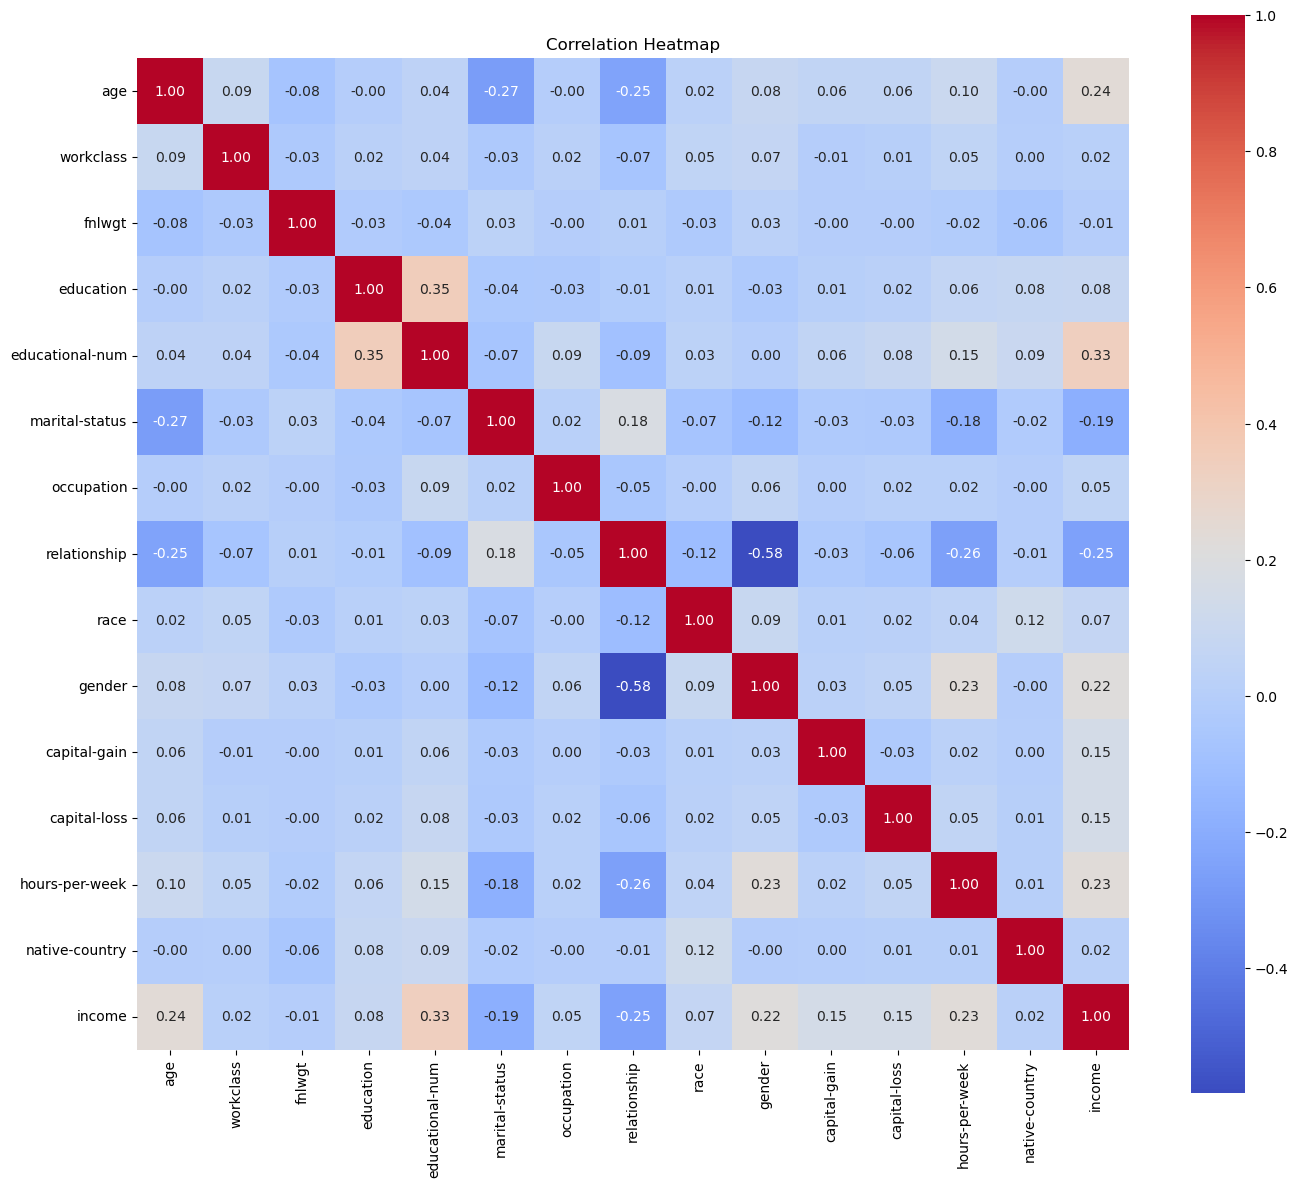

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
correlation_matrix = df.corr()
plt.figure(figsize=(16, 14))  
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.show()


# Step 7: Implement the first classification method, K-Nearest Neighbors (KNN), achieving an accuracy of 84% through cross-validation.


In [47]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score

y = df['income'] #target
X = df.drop(columns=['income']) # features
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
k_values = range(1, 31)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
optimal_k = k_values[cv_scores.index(max(cv_scores))]
print(f"Optimal K: {optimal_k}")
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(X_train, y_train)
accuracy = knn_optimal.score(X_test, y_test)
print(f"Test Accuracy with Optimal K: {accuracy:.2f}")




Optimal K: 18
Test Accuracy with Optimal K: 0.85


# Step8: Implement the second classification method, Support Vector Machine (SVM), and determine the best kernel for this dataset.


In [ ]:
from sklearn.svm import SVC

y = df['income'] #target
X = df.drop(columns=['income']) # features
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
linear_svm = SVC(kernel='linear', C=1.5)
poly_svm = SVC(kernel='poly', degree=3, C=1.5)
rbf_svm = SVC(kernel='rbf', gamma=0.7, C=1.5)
sigmoid_svm = SVC(kernel='sigmoid', C=1.5)
linear_svm.fit(X_train, y_train)
poly_svm.fit(X_train, y_train)
rbf_svm.fit(X_train, y_train)
sigmoid_svm.fit(X_train, y_train)
print(f"Linear Kernel Accuracy: {linear_acc:.2f}")
print(f"Polynomial Kernel Accuracy: {poly_acc:.2f}")
print(f"RBF Kernel Accuracy: {rbf_acc:.2f}")
print(f"Sigmoid Kernel Accuracy: {sigmoid_acc:.2f}")

# Step 9: Use the third classification method, Decision Tree Classifier, and evaluate its accuracy.


Accuracy: 0.8098326822436795

Confusion Matrix:
 [[8949 1330]
 [1250 2038]]


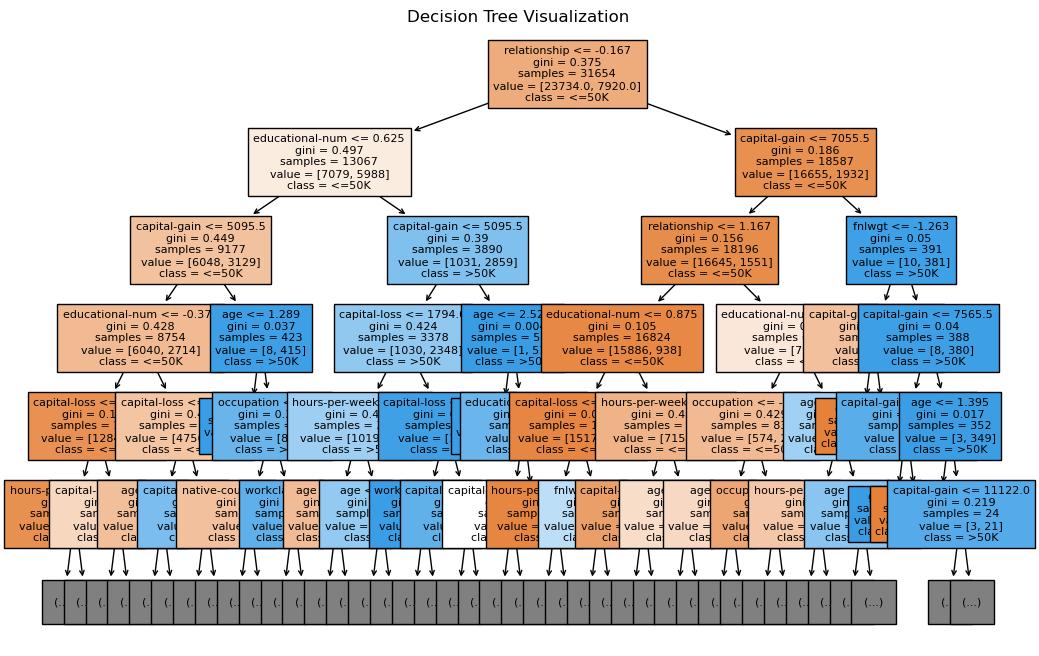

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


y = df['income']  # Target
X = df.drop(columns=['income'])  # Features


label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


clf = DecisionTreeClassifier(random_state=42, criterion='gini')

clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


plt.figure(figsize=(12, 8))
tree.plot_tree(clf, filled=True, feature_names=X.columns, class_names=clf.classes_ , max_depth= 5 ,fontsize=8 )
plt.title("Decision Tree Visualization")
plt.show()


# Step 10: Enhance the Decision Tree's performance with AdaBoostClassifier, which improves accuracy by 6%.


E:\Anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.86


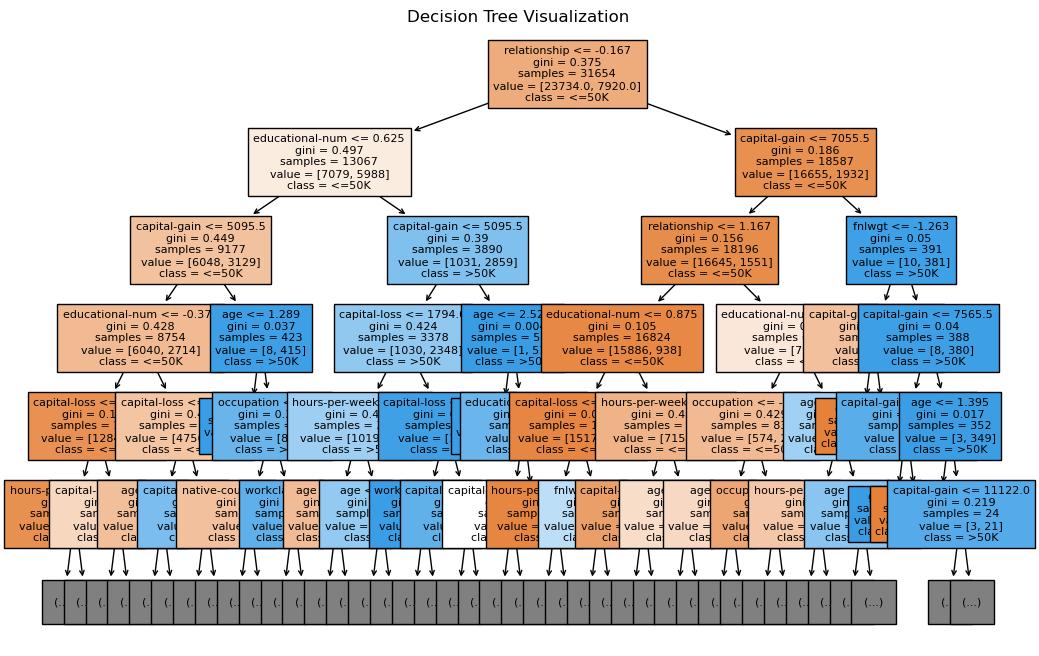

In [36]:
from sklearn.ensemble import AdaBoostClassifier
y = df['income']  # Target
X = df.drop(columns=['income'])  # Features

label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

base_estimator = DecisionTreeClassifier(max_depth=1)

adaboost = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=50,  # Number of weak learners
    learning_rate=1.0,  # Learning rate
    random_state=42
)

adaboost.fit(X_train, y_train)

y_pred = adaboost.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
plt.figure(figsize=(12, 8))
tree.plot_tree(clf, filled=True, feature_names=X.columns, class_names=clf.classes_ , max_depth= 5 ,fontsize=8 )
plt.title("Decision Tree Visualization")
plt.show()

# Step 11: Enhance the Decision Tree's performance with AdaBoostClassifier, which improves accuracy by 6%.


Accuracy: 0.8536890985479473

Confusion Matrix:
 [[9530  749]
 [1236 2052]]


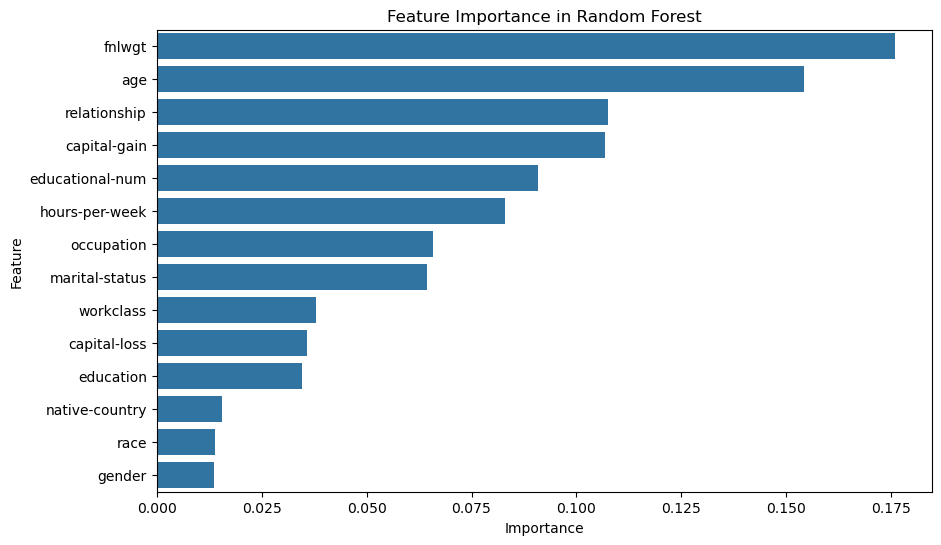

In [38]:
from sklearn.ensemble import RandomForestClassifier

y = df['income']  # Target
X = df.drop(columns=['income'])  # Features

label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Get feature importances
importances = rf_clf.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance in Random Forest')
plt.show()

# Step 12: Implement the fourth classification method, Random Forest Classifier, and assess its accuracy.


In [43]:
import xgboost as xgb

y = df['income']  # Target
X = df.drop(columns=['income'])  # Features

label_encoders = {}
le_target = LabelEncoder() 
y = le_target.fit_transform(y) 
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
# Set the parameters for the XGBoost model
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': 3,  # Number of classes in the target variable
    'max_depth': 3,  # Maximum depth of a tree
    'eta': 0.1,  # Learning rate
    'subsample': 0.8,  # Subsample ratio of the training instances
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'eval_metric': 'mlogloss',  # Evaluation metric
    'seed': 42  # Random seed for reproducibility
}

# Train the XGBoost model
num_round = 100  # Number of boosting rounds
bst = xgb.train(params, dtrain, num_round)

# Make predictions on the test set
y_pred = bst.predict(dtest)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.86


# Conclusion: Both XGBoost and AdaBoost achieved similar accuracy, but XGBoost was faster, making it the most efficient model for this dataset.
